In [1]:
# Autor: Márcio de Carvalho Saraiva
# contato: marciosaraivac2@gmail.com
# Versão: 1.0
# Data: 12/04/2020

# Contexto

O presente problema se refere aos dados de vinhos portugueses "Vinho Verde", 
que possuem variantes de vinho branco e tinto. Devido a questões de privacidade,
apenas variáveis físico-químicas (input) e sensoriais (output) estão disponíveis 
(por exemplo, não há dados sobre tipo de uva, marca do vinho, preço de venda, etc).

# Objetivo

Criar um modelo para estimar a qualidade do vinho.

# Variáveis

Variáveis input (baseado em testes físico-químicos):
1. Tipo
2. Acidez fixa
3. Volatilidade da acidez
4. Ácido cítrico
5. Açúcar residual
6. Cloretos
7. Dióxido de enxofre livre
8. Dióxido de enxofre total
9. Densidade
10. pH
11. Sulfatos
12. Álcool

Variável output (baseado em dado sensorial):
13. Qualidade (score entre 0 and 10)

# Imports

In [2]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scikitplot as skplt

from imblearn.over_sampling import SMOTE

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, normalize
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

from sklearn.linear_model import LogisticRegression

from sklearn.ensemble import RandomForestClassifier

from sklearn.tree import DecisionTreeClassifier

from sklearn.neighbors import KNeighborsClassifier

# Funções

In [3]:
def exibe_matriz_confunsao(rfc, X_test,y_test):

    y_pred = rfc.predict(X_test)
    
    skplt.metrics.plot_confusion_matrix(y_test, y_pred, normalize=True)
    skplt.metrics.plot_confusion_matrix(y_test, y_pred, normalize=False)
    
    plt.show()

# Paths

In [4]:
INPUT_WINE_DATA = "winequality.csv"

# INPUT DATA

In [5]:
wine_data = pd.read_csv(INPUT_WINE_DATA, sep=';')

In [6]:
wine_data.head()

,type,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,White,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,White,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,White,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,White,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,White,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


In [7]:
# Quantidade de dados

wine_data.shape

(6497, 13)

In [8]:
# Removendo registros duplicados
wine_data = wine_data.drop_duplicates()

wine_data.shape

(5320, 13)

# Análise Exploratória dos Dados

In [9]:
# Conferindo os tipos das colunas do DataFrame com dados de Vinho
wine_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5320 entries, 0 to 6496
Data columns (total 13 columns):
type                    5320 non-null object
fixed acidity           5320 non-null float64
volatile acidity        5320 non-null float64
citric acid             5320 non-null float64
residual sugar          5320 non-null float64
chlorides               5320 non-null float64
free sulfur dioxide     5320 non-null float64
total sulfur dioxide    5320 non-null float64
density                 5320 non-null float64
pH                      5320 non-null float64
sulphates               5320 non-null float64
alcohol                 5320 non-null object
quality                 5320 non-null int64
dtypes: float64(10), int64(1), object(2)
memory usage: 581.9+ KB


In [10]:
wine_data.type.value_counts()

White    3961
Red      1359
Name: type, dtype: int64

In [11]:
# A variável Type possue apenas dois valores: White e Red. Para facilitar o aprendizado do Modelo, esses valores foram substituidos por 0 e 1, respectivamente.
wine_data['type'].replace({"White": 0, "Red": 1}, inplace=True)

In [12]:
wine_data.type.value_counts()

0    3961
1    1359
Name: type, dtype: int64

In [13]:
# A variável 'alcohol' foi lida como object, porém seus dados são float. A conversão manual é necessária. 

wine_data['alcohol'] = pd.to_numeric(wine_data['alcohol'],errors='coerce')

In [14]:
wine_data.describe()

,type,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,5320.000000,5320.000000,5320.000000,5320.000000,5320.000000,5320.000000,5320.000000,5320.000000,5320.000000,5320.000000,5320.000000,5288.000000,5320.000000
mean,0.255451,7.215179,0.344130,0.318494,5.048477,0.056690,30.036654,114.109023,1.674335,3.224664,0.533357,10.546874,5.795677
std,0.436155,1.319671,0.168248,0.147157,4.500180,0.036863,17.805045,56.774223,7.494908,0.160379,0.149743,1.186073,0.879772
min,0.000000,3.800000,0.080000,0.000000,0.600000,0.009000,1.000000,6.000000,0.987110,2.720000,0.220000,8.000000,3.000000
25%,0.000000,6.400000,0.230000,0.240000,1.800000,0.038000,16.000000,74.000000,0.992200,3.110000,0.430000,9.500000,5.000000
50%,0.000000,7.000000,0.300000,0.310000,2.700000,0.047000,28.000000,116.000000,0.994650,3.210000,0.510000,10.400000,6.000000
75%,1.000000,7.700000,0.410000,0.400000,7.500000,0.066000,41.000000,153.250000,0.996770,3.330000,0.600000,11.400000,6.000000
max,1.000000,15.900000,1.580000,1.660000,65.800000,0.611000,289.000000,440.000000,103.898000,4.010000,2.000000,14.900000,9.000000


In [15]:
# Verificando a quantidade de valores null
wine_data.isnull().sum() 

type                     0
fixed acidity            0
volatile acidity         0
citric acid              0
residual sugar           0
chlorides                0
free sulfur dioxide      0
total sulfur dioxide     0
density                  0
pH                       0
sulphates                0
alcohol                 32
quality                  0
dtype: int64

### Como vimos anteriormente, a coluna "alcohol" possui 32 valores null. Por serem poucos valores, vamos preenche-los com a média dessa coluna. 

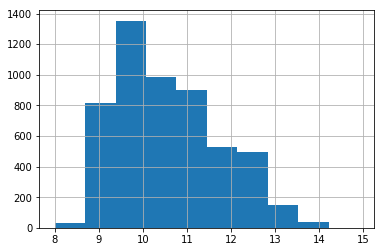

In [16]:
# Analisando o histograma de "alcohol" podemos ver que poucos registros estão nas extremidades. 
# Por isso, vamos remover as extremidades para evitar outliers ao calcular a média.

wine_data.alcohol.hist()

In [17]:
# Para determinar onde será nosso "corte", utilizamos a visualização de quantis

wine_data.alcohol.quantile([.1,.25,.5,.75,.9])

0.10     9.2
0.25     9.5
0.50    10.4
0.75    11.4
0.90    12.3
Name: alcohol, dtype: float64

In [18]:
# Removemos os 10% menores valores e os 10% maiores para calcular a média da coluna "alcohol"
# Esta média será utilizada para preencher os valores faltantes.

wine_data.alcohol = wine_data.alcohol.fillna(wine_data.alcohol[(wine_data.alcohol > wine_data.alcohol.quantile(.1)) & (wine_data.alcohol < wine_data.alcohol.quantile(.9))].mean())

In [19]:
wine_data.alcohol.describe()

count    5320.00000
mean       10.54648
std         1.18251
min         8.00000
25%         9.50000
50%        10.40000
75%        11.40000
max        14.90000
Name: alcohol, dtype: float64

# Análise da Correlação entre as variáveis

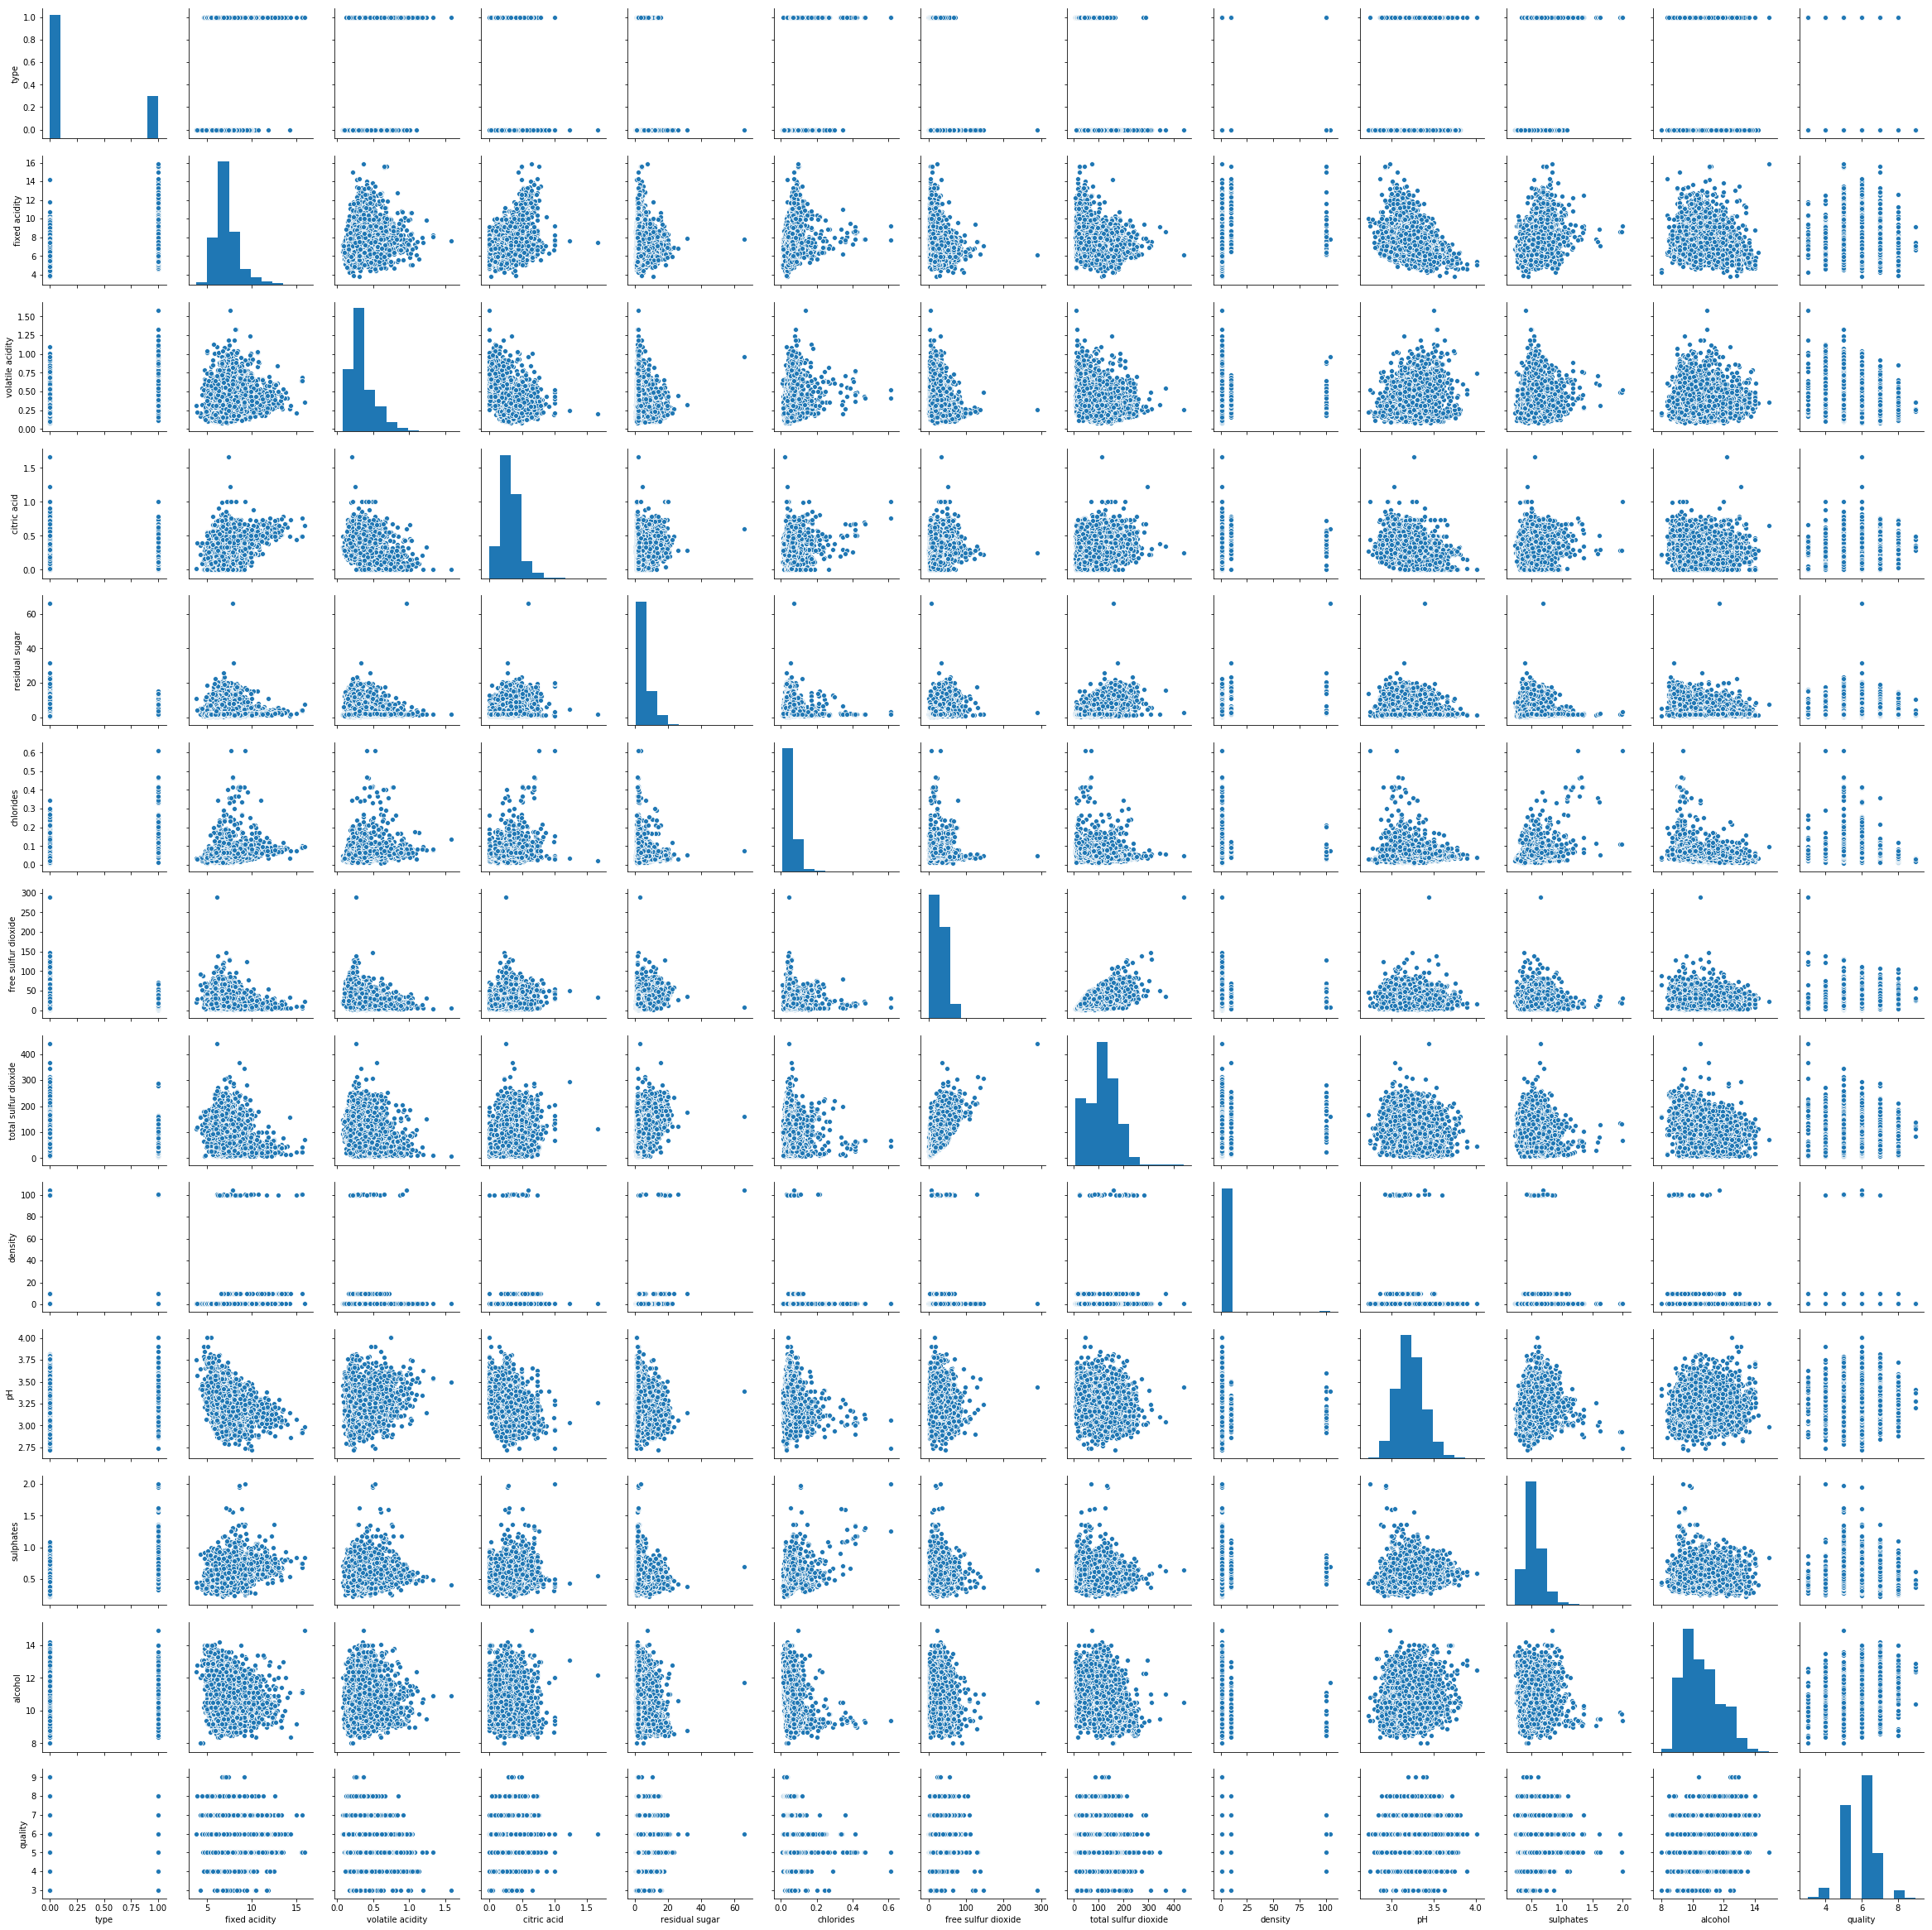

In [20]:
sns.pairplot(wine_data)

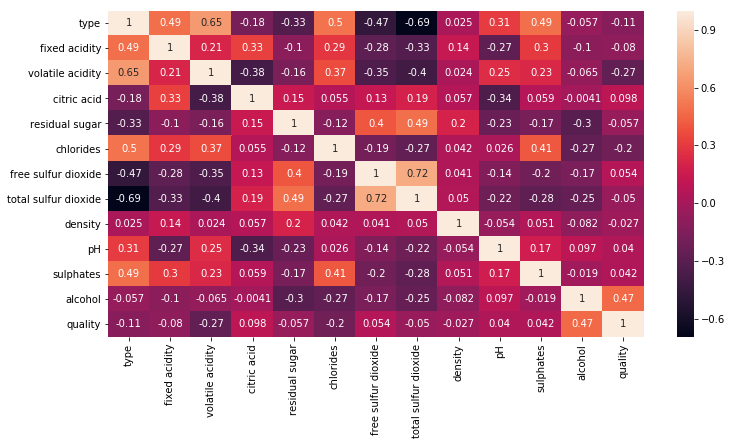

In [21]:
plt.figure(figsize=(12,6))
sns.heatmap(wine_data.corr(),annot=True)

### Como podemos ver, quase todas as variáveis não possuem correlação forte. Apenas entre "free sulfur dioxide" e "total sulfur dioxide", e entre "total sulfur dioxide" e "type" encontramos correlação forte. Em um cenário onde cortes de variáveis fossem necessários, poderiamos eliminar uma dessas variáveis. A variável com maior correlação com a variável resposta ("quality") é "alcohol".

# Observando a variável resposta - quality

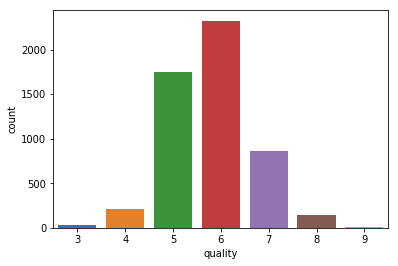

In [22]:
sns.countplot(x='quality', data=wine_data)

In [23]:
wine_data.quality.value_counts()

6    2323
5    1752
7     856
4     206
8     148
3      30
9       5
Name: quality, dtype: int64

In [24]:
wine_data.quality.value_counts(normalize=True)

6    0.436654
5    0.329323
7    0.160902
4    0.038722
8    0.027820
3    0.005639
9    0.000940
Name: quality, dtype: float64

# Processando dados para gerar Modelo

In [25]:
#Separando variável resposta e variáveis features
X = wine_data.drop('quality', axis = 1)
y = wine_data['quality']

In [26]:
# Escalonando os dados

sc = StandardScaler()
X = sc.fit_transform(X)

In [27]:
#Dividindo Treino e Teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [28]:
# Normalizando os dados

X_train = normalize(X_train, norm='l2', axis=1, copy=True, return_norm=False)
X_test = normalize(X_test, norm='l2', axis=1, copy=True, return_norm=False)

### Avaliando necessidade de PCA

In [29]:
#PCA
pca = PCA()
x_pca = pca.fit_transform(X)

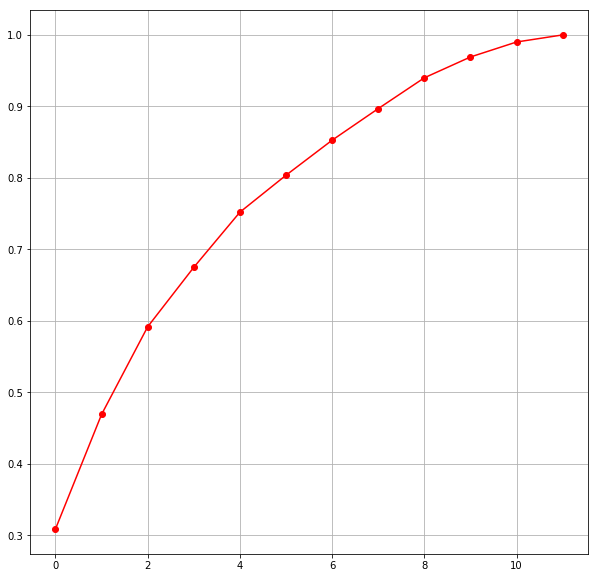

In [30]:
#Principais componentes

plt.figure(figsize=(10,10))
plt.plot(np.cumsum(pca.explained_variance_ratio_), 'ro-')
plt.grid()

Conforme o gráfico, podemos ver que 8 componentes principais atribuem aproximadamente 95% da variação nos dados.

Poderiamos então escolher os 8 primeiros componentes para previsão da qualidade do vinho.

Porém, foi visto que isto não traria grandes mudanças para a velocidade da solução nem para a melhora dos resultados.

Por isso, não utilizaremos o pca.

Se você desejar utilizar o pca a fim de comparação e estudo, utilize o código abaixo:



In [31]:
#pca_new = PCA(n_components=8)
#X = pca_new.fit_transform(x)

#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)
#X_train = normalize(X_train, norm='l2', axis=1, copy=True, return_norm=False)
#X_test = normalize(X_test, norm='l2', axis=1, copy=True, return_norm=False)

# Modelos

In [32]:
# Random Forest

rfc = RandomForestClassifier(n_estimators=200)
rfc.fit(X_train, y_train)
pred_rfc = rfc.predict(X_test)

rfc.score(X_test, y_test)

0.568609022556391

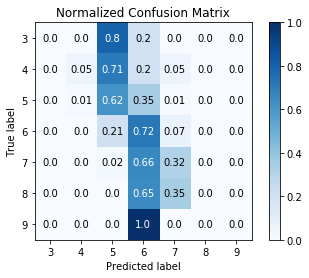

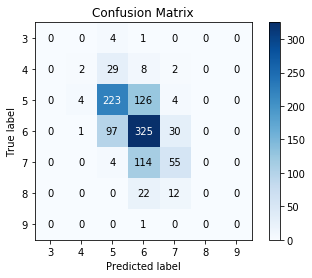

In [33]:
exibe_matriz_confunsao(rfc, X_test,y_test)

In [34]:
# Outras métricas de desempenho do modelo

print(classification_report(y_test, pred_rfc))

              precision    recall  f1-score   support

           3       0.00      0.00      0.00         5
           4       0.29      0.05      0.08        41
           5       0.62      0.62      0.62       357
           6       0.54      0.72      0.62       453
           7       0.53      0.32      0.40       173
           8       0.00      0.00      0.00        34
           9       0.00      0.00      0.00         1

   micro avg       0.57      0.57      0.57      1064
   macro avg       0.28      0.24      0.25      1064
weighted avg       0.54      0.57      0.54      1064



In [35]:
rfc_eval = cross_val_score(estimator = rfc, X = X_train, y = y_train, cv = 10)
rfc_eval.mean()

0.5747412887106889

# Features Importances

Feature ranking:
1. alcohol (indice 11) (0.139870)
2. volatile acidity (indice 2) (0.097428)
3. chlorides (indice 5) (0.087377)
4. sulphates (indice 10) (0.082828)
5. free sulfur dioxide (indice 6) (0.082187)
6. total sulfur dioxide (indice 7) (0.077683)
7. pH (indice 9) (0.076452)
8. citric acid (indice 3) (0.075190)
9. residual sugar (indice 4) (0.074225)
10. fixed acidity (indice 1) (0.073973)
11. type (indice 0) (0.068047)
12. density (indice 8) (0.064742)


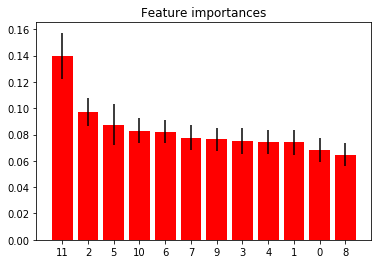

In [36]:
importances = rfc.feature_importances_
std = np.std([tree.feature_importances_ for tree in rfc.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Exibe o feature ranking
print("Feature ranking:")

for f in range(X.shape[1]):
    print("%d. %s (indice %d) (%f)" % (f + 1, wine_data.columns[indices[f]], indices[f], importances[indices[f]]))

# Plot: feature importances
plt.figure()
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), indices)
plt.xlim([-1, X.shape[1]])
plt.show()

# Testando outros algoritmos

In [37]:
# Regressão Logistica
lr = LogisticRegression()
lr.fit(X_train, y_train)
lr_predict = lr.predict(X_test)
lr_eval = cross_val_score(estimator = lr, X = X_train, y = y_train, cv = 10)
print(lr_eval.mean())

0.5383718903259092


In [38]:
# Árvore de decisão

dt = DecisionTreeClassifier()
dt.fit(X_train,y_train)
dt_predict = dt.predict(X_test)
dt_eval = cross_val_score(estimator = dt, X = X_train, y = y_train, cv = 10)
print(dt_eval.mean())

0.4507857773132559


In [39]:
# Classificador KNN
neigh = KNeighborsClassifier(n_neighbors=3)
neigh.fit(X_train, y_train)
neigh.score(X_test, y_test)
neigh_eval = cross_val_score(estimator = neigh, X = X_train, y = y_train, cv = 10)
print(neigh_eval.mean())

0.4762866438600001


### Como podemos ver, o Random Forrest é o melhor algoritmo.

# Alterando o Target

Buscando aprimorar os resultados obtidos, iremos mudar a variabilidade do target.

Será criado uma nova coluna no DataFrame com dados de vinhos, chamada new_quality. Essa coluna irá conter valores 1, 2 e 3, onde 1 - baixa qualidade, 2- média qualidade, 3- alta qualidade.

De acordo com a distribuição observada da qualidade, temos:

1 até 5 será Baixa qualidade
6 será Média qualidade
7 a 10 será Alta qualidade


In [40]:
new_quality = []

for quality in wine_data['quality']:
    if 1<=quality<=5:
        new_quality.append('1')
    elif quality==6:
        new_quality.append('2')
    else:
        new_quality.append('3')
        
wine_data['new_quality'] = new_quality

# Processando novamente dados para o Modelo

In [41]:
#Separando variável resposta e variáveis features
X = wine_data.drop(['quality', 'new_quality'], axis = 1)
y = wine_data['new_quality']

In [42]:
# Escalonando os dados

sc = StandardScaler()
X = sc.fit_transform(X)

In [43]:
#Dividindo Treino e Teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [44]:
# Normalizando os dados

X_train = normalize(X_train, norm='l2', axis=1, copy=True, return_norm=False)
X_test = normalize(X_test, norm='l2', axis=1, copy=True, return_norm=False)

In [45]:
#fazendo oversampling do treino

sm = SMOTE(random_state=42)

X_train, y_train = sm.fit_sample(X_train, y_train)

In [46]:
# Random Forest

rfc = RandomForestClassifier(n_estimators=200)
rfc.fit(X_train, y_train)
pred_rfc = rfc.predict(X_test)
rfc.score(X_test, y_test)

0.6212406015037594

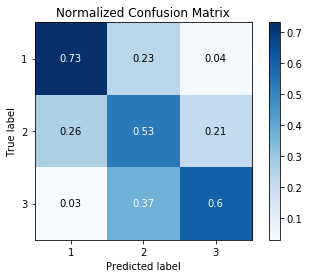

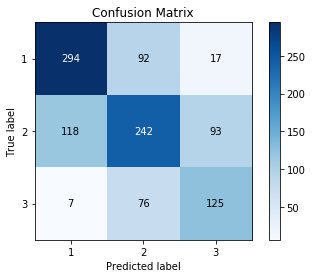

In [47]:
exibe_matriz_confunsao(rfc, X_test,y_test)

In [48]:
print(classification_report(y_test, pred_rfc))

              precision    recall  f1-score   support

           1       0.70      0.73      0.72       403
           2       0.59      0.53      0.56       453
           3       0.53      0.60      0.56       208

   micro avg       0.62      0.62      0.62      1064
   macro avg       0.61      0.62      0.61      1064
weighted avg       0.62      0.62      0.62      1064



In [49]:
rfc_eval = cross_val_score(estimator = rfc, X = X_train, y = y_train, cv = 10)
rfc_eval.mean()

0.7210338680926917

# Features Importances

Feature ranking:
1. alcohol (indice 11) (0.171022)
2. volatile acidity (indice 2) (0.096885)
3. chlorides (indice 5) (0.093690)
4. sulphates (indice 10) (0.081620)
5. free sulfur dioxide (indice 6) (0.076635)
6. total sulfur dioxide (indice 7) (0.075608)
7. citric acid (indice 3) (0.075533)
8. pH (indice 9) (0.072580)
9. fixed acidity (indice 1) (0.070935)
10. residual sugar (indice 4) (0.070614)
11. type (indice 0) (0.059780)
12. density (indice 8) (0.055099)


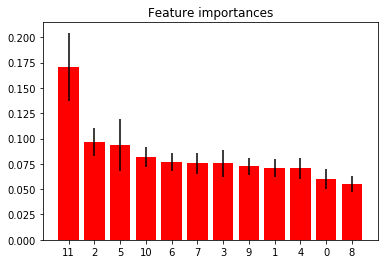

In [50]:
importances = rfc.feature_importances_
std = np.std([tree.feature_importances_ for tree in rfc.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Exibe o feature ranking
print("Feature ranking:")

for f in range(X.shape[1]):
    print("%d. %s (indice %d) (%f)" % (f + 1, wine_data.columns[indices[f]], indices[f], importances[indices[f]]))

# Plot: feature importances
plt.figure()
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), indices)
plt.xlim([-1, X.shape[1]])
plt.show()

# Alterando o Target novamente

Agora vamos testar com apenas dois rótulos no target.

Vou criar uma nova coluna no DataFrame com dados de vinhos, chamada new_quality2. Essa coluna irá conter valores 1, 2 onde 1 - baixa qualidade, 2- alta qualidade.

De acordo com a distribuição observada da qualidade, temos:

1 até 5 será Baixa qualidade
6 a 10 será Alta qualidade


In [51]:
new_quality = []

for quality in wine_data['quality']:
    if quality<=6:
        new_quality.append('1')
    else:
        new_quality.append('2')
        
wine_data['new_quality2'] = new_quality

# Processando pela terceira vez os dados para o Modelo

In [52]:
#Separando variável resposta e variáveis features
X = wine_data.drop(['quality', 'new_quality', 'new_quality2'], axis = 1)
y = wine_data['new_quality2']

In [53]:
# Escalonando os dados

sc = StandardScaler()
X = sc.fit_transform(X)

In [54]:
#Dividindo Treino e Teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [55]:
# Normalizando os dados

X_train = normalize(X_train, norm='l2', axis=1, copy=True, return_norm=False)
X_test = normalize(X_test, norm='l2', axis=1, copy=True, return_norm=False)

In [56]:
#fazendo oversampling do treino

sm = SMOTE(random_state=42)

X_train, y_train = sm.fit_sample(X_train, y_train)

In [57]:
# Random Forest

rfc = RandomForestClassifier(n_estimators=200)
rfc.fit(X_train, y_train)
pred_rfc = rfc.predict(X_test)
rfc.score(X_test, y_test)

0.8261278195488722

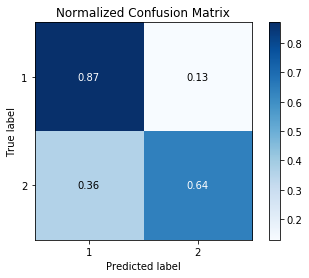

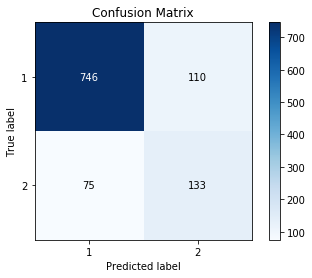

In [58]:
exibe_matriz_confunsao(rfc, X_test,y_test)

In [59]:
print(classification_report(y_test, pred_rfc))

              precision    recall  f1-score   support

           1       0.91      0.87      0.89       856
           2       0.55      0.64      0.59       208

   micro avg       0.83      0.83      0.83      1064
   macro avg       0.73      0.76      0.74      1064
weighted avg       0.84      0.83      0.83      1064



In [60]:
rfc_eval = cross_val_score(estimator = rfc, X = X_train, y = y_train, cv = 10)
rfc_eval.mean()

0.9094202898550725

# Features Importances

Feature ranking:
1. alcohol (indice 11) (0.217134)
2. chlorides (indice 5) (0.096009)
3. volatile acidity (indice 2) (0.091693)
4. sulphates (indice 10) (0.080494)
5. citric acid (indice 3) (0.075186)
6. total sulfur dioxide (indice 7) (0.075039)
7. free sulfur dioxide (indice 6) (0.067917)
8. residual sugar (indice 4) (0.067645)
9. pH (indice 9) (0.066559)
10. fixed acidity (indice 1) (0.063103)
11. type (indice 0) (0.052095)
12. density (indice 8) (0.047126)


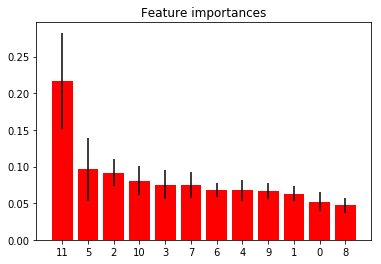

In [61]:
importances = rfc.feature_importances_
std = np.std([tree.feature_importances_ for tree in rfc.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Exibe o feature ranking
print("Feature ranking:")

for f in range(X.shape[1]):
    print("%d. %s (indice %d) (%f)" % (f + 1, wine_data.columns[indices[f]], indices[f], importances[indices[f]]))

# Plot: feature importances
plt.figure()
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), indices)
plt.xlim([-1, X.shape[1]])
plt.show()

# Conclusão

Quanto menor a quantidade de classes de qualidade do vinho para predição, melhor o desempenho do modelo:
    
- Com a qualidade do vinho com as classes 3 a 9, nosso modelo tem score em média igual a 56%

- Com a qualidade do vinho com as classes 1 a 3, nosso modelo tem score em média igual a 71%

- Com a qualidade do vinho com as classes 1 ou 2, nosso modelo tem score em média igual a 90%